In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress
#tqdm().pandas()

### Data Cleaning

All image captions are available in the Flickr 8k.token file of the Flickr_8k_text folder. Each image and caption separated by a new line and carry 5 captions numbered from 0 to 4 along with.

In [3]:
#Fn to load the document file and read the contents of the file into a string.
def load_doc(filename):
  # Open file to read
   file = open(filename, 'r')
   text = file.read()
   file.close()
   return text

In [4]:
#To create a description dictionary that will map each image with all 5 captions corresponding to it.
def img_capt(filename):
  file = load_doc(filename)
  #Read the filename caption pairs
  captions = file.split('\n')
  descriptions ={}
  for caption in captions[:-1]:
    #Extract each image and caption seperately
    img, caption = caption.split('\t')
    #Extract name of the image alone  and if not present in the descriptions add new key value pair else append to existing key
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [ caption ]
    else:
      descriptions[img[:-2]].append(caption)
  return descriptions

In [5]:
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers for the captions
def txt_clean(captions):
   #maketrans() method returns a mapping table for translation usable for translate() method for removing punctuation
   table = str.maketrans('','',string.punctuation)
   for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
      img_caption.replace("-"," ")
      desc = img_caption.split()
    #uppercase to lowercase
      desc = [wrd.lower() for wrd in desc]
    #remove punctuation from each token
      desc = [wrd.translate(table) for wrd in desc]
    #remove hanging 's and a
      desc = [wrd for wrd in desc if(len(wrd)>1)]
    #remove words containing numbers with them
      desc = [wrd for wrd in desc if(wrd.isalpha())]
    #converting back to string
      img_caption = ' '.join(desc)
      captions[img][i]= img_caption
   return captions

In [6]:
#Create vocabulary set from the unique words extracted
def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

In [7]:
#To save all image-caption pairs in a text file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + 't' + desc )
    data = "n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


In [8]:
# Set these path according to project folder
# dataset_text = "Image Caption GeneratorFlickr_8k_text"
dataset_images = "/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator/Flickr8k_Dataset/Flicker8k_Dataset"
#to prepare our text data
filename = '/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator/Flickr8k_text/Flickr8k.token.txt'
#loading the file that contains all data
#Create descriptions dictionary for each image with correspondingcaption list
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the captions for the images in the descriptions dictionary
clean_descriptions = txt_clean(descriptions)
# #to build vocabulary set
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving the descriptions dictionary in a text file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


KeyboardInterrupt: ignored

In [ ]:
#Fn for feature extraction. The features dictionary will be saved into a pickle file
def extract_features(dirc):
  #Here the pre-trained model called Xception will be used in the CNN layer to extract features from the images
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  #Iterate through the images
  for pic in tqdm(os.listdir(dirc)):
    file = dirc + "/" + pic
    image = Image.open(file)
    #The xception model takes 299*299*3 image size as input
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    #image = preprocess_input(image)
    #Normalize image
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    features[pic] = feature
  return features

In [ ]:
features = extract_features(dataset_images)

  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


{'1229756013_94663527d7.jpg': array([[0.10863486, 0.7728471 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '2977246776_b14be8290d.jpg': array([[0.        , 0.02347268, 0.0114992 , ..., 0.        , 0.05899194,
         0.00323059]], dtype=float32),
 '2752230113_b5dab6f0f1.jpg': array([[0.02278591, 0.06665532, 0.058604  , ..., 0.2041615 , 0.        ,
         0.19505467]], dtype=float32),
 '693785581_68bec8312a.jpg': array([[0.03941134, 0.        , 0.5395902 , ..., 0.15284595, 0.103085  ,
         0.25135043]], dtype=float32),
 '2589308405_e208b5e745.jpg': array([[6.7100756e-02, 4.9056057e-03, 1.5718827e-01, ..., 3.0091807e-01,
         0.0000000e+00, 1.3901631e-04]], dtype=float32),
 '3585598356_8ce815bbb9.jpg': array([[0.        , 0.00073294, 0.0357591 , ..., 0.        , 0.00051243,
         0.26227212]], dtype=float32),
 '150387174_24825cf871.jpg': array([[0.20951484, 0.04881971, 0.        , ..., 0.08473884, 0.1127565 ,
         0.00671616]], dtype=

In [ ]:
#Dictionary with the image name and features
features

{'1229756013_94663527d7.jpg': array([[0.10863486, 0.7728471 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '2977246776_b14be8290d.jpg': array([[0.        , 0.02347268, 0.0114992 , ..., 0.        , 0.05899194,
         0.00323059]], dtype=float32),
 '2752230113_b5dab6f0f1.jpg': array([[0.02278591, 0.06665532, 0.058604  , ..., 0.2041615 , 0.        ,
         0.19505467]], dtype=float32),
 '693785581_68bec8312a.jpg': array([[0.03941134, 0.        , 0.5395902 , ..., 0.15284595, 0.103085  ,
         0.25135043]], dtype=float32),
 '2589308405_e208b5e745.jpg': array([[6.7100756e-02, 4.9056057e-03, 1.5718827e-01, ..., 3.0091807e-01,
         0.0000000e+00, 1.3901631e-04]], dtype=float32),
 '3585598356_8ce815bbb9.jpg': array([[0.        , 0.00073294, 0.0357591 , ..., 0.        , 0.00051243,
         0.26227212]], dtype=float32),
 '150387174_24825cf871.jpg': array([[0.20951484, 0.04881971, 0.        , ..., 0.08473884, 0.1127565 ,
         0.00671616]], dtype=

In [ ]:
dump(features, open("features.pkl","wb"))
#to directly load the features from the pickle file.
features = load(open("features.pkl","rb"))

In [ ]:
#Flickr_8k.trainImages.txt has list of 6000 image names that are used for training.
#This function takes a file name as input and return the list of image names in file
def load_photos(filename):
  file = load_doc(filename)
  photos = file.split("\n")[:-1]
  return photos

In [ ]:
#This function stores the captions for every image from the list of imagenames to a dictionary.
#For the ease of the LSTM model in identifying the beginning and ending of a caption, we append the and identifier with each caption
def load_clean_descriptions(clean_descrpns, photos):
  descriptions = {}
  for img in photos:
    desc = clean_descrpns[img]
    descriptions[img] = desc
  return descriptions

In [ ]:
#This function stores the captions for every image from the list of imagenames to a dictionary.
#For the ease of the LSTM model in identifying the beginning and ending of a caption, we append the and identifier with each caption
# def load_clean_descriptions(filename, photos):
#   #loading clean_descriptions
#   file = load_doc(filename)
#   descriptions = {}
#   for line in file.split("\n"):
#     words = line.split()
#     if len(words)<1 :
#       continue
#     image, image_caption = words[0], words[1:]
#     if image in photos:
#       if image not in descriptions:
#         descriptions[image] = []
#         desc = ' ' + " ".join(image_caption) + ' '
#         descriptions[image].append(desc)
#   return descriptions

In [ ]:
#The extracted feature vectors from the pickle file for the train images are returned as a dictionary
def load_features(photos):
  #loading all features
  all_features = load(open("/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator/features.pkl","rb"))
  #selecting only needed features
  features = {k:all_features[k] for k in photos}
  return features

In [ ]:
filename = "/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator/Flickr8k_text/Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [ ]:
#Retreive the cleaned descriptions corresponding to the train image names from the descriptions text file
#train_descriptions = load_clean_descriptions("/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator/descriptions.txt", train_imgs)
train_descriptions = load_clean_descriptions(clean_descriptions, train_imgs)
train_descriptions

{'2513260012_03d33305cf.jpg': ['black dog is running after white dog in the snow',
  'black dog chasing brown dog through snow',
  'two dogs chase each other across the snowy ground',
  'two dogs play together in the snow',
  'two dogs running through low lying body of water'],
 '2903617548_d3e38d7f88.jpg': ['little baby plays croquet',
  'little girl plays croquet next to truck',
  'the child is playing croquette by the truck',
  'the kid is in front of car with put and ball',
  'the little boy is playing with croquet hammer and ball beside the car'],
 '3338291921_fe7ae0c8f8.jpg': ['brown dog in the snow has something hot pink in its mouth',
  'brown dog in the snow holding pink hat',
  'brown dog is holding pink shirt in the snow',
  'dog is carrying something pink in its mouth while walking through the snow',
  'dog with something pink in its mouth is looking forward'],
 '488416045_1c6d903fe0.jpg': ['brown dog is running along beach',
  'brown dog wearing black collar running across

In [ ]:
#Return train img: features as a dictionary
train_features = load_features(train_imgs)
train_features

{'2513260012_03d33305cf.jpg': array([[0.        , 0.44815826, 0.        , ..., 0.17757443, 0.00191514,
         0.00869674]], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([[0.17655922, 0.01287617, 0.15669037, ..., 0.077856  , 0.22157334,
         0.07919027]], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([[0.28786087, 0.        , 0.        , ..., 0.        , 0.08850839,
         0.        ]], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([[0.4536432 , 0.        , 0.        , ..., 0.00685248, 0.        ,
         0.        ]], dtype=float32),
 '2644326817_8f45080b87.jpg': array([[0.00466416, 0.00331447, 0.02121837, ..., 0.0794296 , 0.01354521,
         0.        ]], dtype=float32),
 '218342358_1755a9cce1.jpg': array([[0.07323222, 0.01431637, 0.11561749, ..., 0.11935558, 0.07156453,
         0.11425325]], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([[1.1065598e-01, 1.7375521e-04, 3.4686303e-01, ..., 1.2568109e-02,
         1.0891063e-01, 3.8788736e-01]], dtype=

In [ ]:
#Convert each word in vocabulary to numerical representation as a separate unique index
#Using in-built tokenizer function is present in the Keras library to create tokens from train descriptions
#Get list of descriptions from dictionary
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [ ]:
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  #fit_on_texts does the mapping of each word token and its unique integer index index
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

In [ ]:
# give each word an index, and store that into tokenizer.pkl file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

In [ ]:
max_length = max_length(descriptions)
max_length

32

In [ ]:
#Create sequences as input to the LSTM;here desc_list is the list of captions and feature is extracted feature for each train image
def create_sequences(tokenizer, max_length, desc_list, feature):
  X_1, X_2, y = list(), list(), list()
  # move through each description for the image
  for desc in desc_list:
    # encode the sequence ie Transforms each text in texts to a sequence of integers
    seq = tokenizer.texts_to_sequences([desc])[0]
    # divide one sequence into various X,y pairs
    for i in range(1, len(seq)):
      # divide into input and output pair by taking last integer as output sequence
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence to get max length
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      # store
      X_1.append(feature)
      X_2.append(in_seq)
      y.append(out_seq)
  return np.array(X_1), np.array(X_2), np.array(y)

In [ ]:
#Create a Data generator to load data in batches
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      #retrieve photo features
      feature = features[key][0]
      inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
      yield [[inp_image, inp_seq], op_word]

In [ ]:
#To check the shape of the input and output for your model;a is the feature i/p;b is caption i/p and c is the caption o/p
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((37, 2048), (37, 32), (37, 7577))

## From the Functional API, we will use the Keras Model in order to define the structure of the model. It includes:

1.   Feature Extractor –With a dense layer, it will extract the feature from the images of size 2048 and we will decrease the dimensions to 256 nodes.
2.   Sequence Processor – Followed by the LSTM layer, the textual input is handled by this embedded layer.
3. Decoder – We will merge the output of the above two layers and process the dense layer to make the final prediction.

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  # Merging both models
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']    

In [ ]:
epochs = 10
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
  model.save("models/model_" + str(i) + ".h5")

<ipython-input-55-e157fcc4aec0>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 471s 79ms/step - loss: 2.9195


## Testing the model

In [26]:
#Test the model accuracy by inputting test image data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications.xception import Xception
import pickle
# import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

In [27]:
def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for 4 channels images, we need to convert them into 3 channels
  #if image.shape[2] == 4:
  #image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

In [28]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [29]:
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    in_text += ' ' + word
    if word == 'end':
      break
  return in_text

In [30]:
# Access Google Drive Folder
import os
os.chdir("drive/MyDrive")

FileNotFoundError: ignored

In [31]:
%cd MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator

[Errno 2] No such file or directory: 'MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator'
/content/drive/MyDrive/MyAIPracticePjts/ComputerVision_Practice/ImageCaptionGenerator


In [34]:
max_length = 32
data = open("tokenizer.pkl","rb")
tokenizer = pickle.load(data)
model = load_model('model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

In [39]:
#img_path='Flickr8k_Dataset/Flicker8k_Dataset/667626_18933d713e.jpg'
img_path='/content/Girlsplaying.jpg'

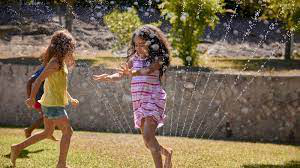

In [40]:
image = Image.open(img_path)
image

In [42]:
photo = extract_features(img_path, xception_model)


1/1 [==============================] - 0s 23ms/step


Title
start is touching children having fun in the grass with their hands on the beach with trees in the background and the background and the people in the background and the flowers in


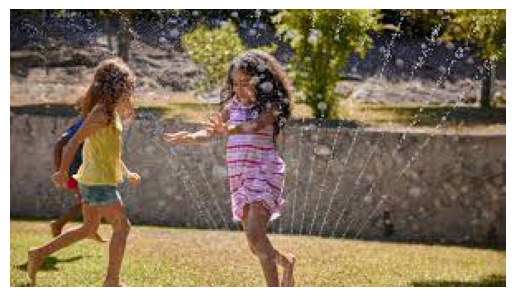

In [43]:
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("Title")
print(description)
plt.axis('off')
plt.imshow(img)
plt.show()